In [1]:
import os
import csv
import cv2
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [2]:
# Data log
def getLines(log_filepath):
    """
    Returns the lines from a driving log with base directory `log_filepath`.
    """
    lines = []
    with open(log_filepath) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

In [3]:
# Loading data 
def load_data(log_filepath, img_filepath, correction = 0.23):
    """
    Returns the lines from a driving log with base directory `log_filepath`.
    """
    lines = getLines(log_filepath)
    images = []
    measurements = []
    for line in lines:
        for source_path in line[0:3]:
            filename = source_path.split('\\')[-1]
            current_path = img_filepath + filename
            measurement = float(line[3])
            if source_path == line[1]:
                measurement = measurement + correction
            if source_path == line[2]:
                measurement = measurement - correction            
            image = np.asarray(Image.open(current_path))
            images.append(image)
            measurements.append(measurement)
    # print('data set size: %d' %(len(measurements)))
    return images, measurements

In [4]:
# Data augumentation 
def random_flip(image, measurement):
    """
    Horizontal flip the image
    """
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
        measurement = measurement*-1
    return image, measurement

def random_translate(image, measurement, range_x=100, range_y=10):
    """
    Randomly shift the image vertically and horizontally 
    """
    trans_x = range_x*(np.random.rand() - 0.5)
    trans_y = range_y*(np.random.rand() - 0.5)
    measurement += trans_x*0.002
    trans_m = np.mat([[1.0, 0.0, trans_x],[0.0, 1.0, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, measurement

def random_shadow(image):
    """
    Generates and adds random shadow
    """
    x1, y1 = image.shape[1]*np.random.rand(), 0
    x2, y2 = image.shape[1]*np.random.rand(), image.shape[0]
    xm, ym = np.mgrid[0:image.shape[0], 0:image.shape[1]]

    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform (low = 0.2, high = 0.5)

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond]*s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

def random_brighness(image):
    """
    Randomly adjust brightness of the image
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    b_ratio = 1.0 + 0.4*(np.random.rand() - 0.5)
    hsv[:, :, 2] = hsv[:, :, 2] * b_ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def data_augumentation(images, measurements):
    augumented_images, augumented_measurements = [],[]
    for image, measurement in zip(images, measurements):        
        augumented_images.append(image)
        augumented_measurements.append(measurement)
        image, measurement = random_flip(image, measurement)
        image, measurement = random_translate (image, measurement)
        image = random_shadow(image)
        image = random_brighness(image)
        augumented_images.append(image)
        augumented_measurements.append(measurement)
    return augumented_images, augumented_measurements

In [5]:
def generator(samples, batch_size = 256):
    num_samples = len(samples)

    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for image, measurement in batch_samples:
                # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [6]:
# Model Construction 
# Creates NVIDIA Autonomous Car Group model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Flatten, Dense, Lambda, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
def model(): 
    """
    Creates NVIDIA Autonomous Car Group model
    """       
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3))) # Normalizing the data
    model.add(Cropping2D(cropping=((50,20), (0,0)))) # Cropping the image
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

Using TensorFlow backend.


In [7]:
# Data preparation
log_filepath = '../data/driving-data/driving_log.csv'
img_filepath = '../data/driving-data/IMG/'
images_original, measurements_original = load_data(log_filepath, img_filepath, correction = 0.23)

In [8]:
images, measurements = data_augumentation(images_original, measurements_original)
images, measurements = sklearn.utils.shuffle(images, measurements)
print('data set size: %d' %(len(measurements)))

data set size: 35916


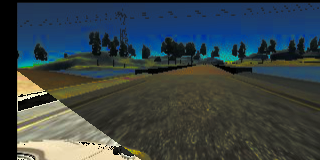

In [18]:
img = Image.fromarray(images[25459].astype('uint8')).convert('RGB')
img

In [19]:
img.save('./img/augumented02.jpg')

In [ ]:
from sklearn.model_selection import train_test_split
samples = list(zip(images, measurements))
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

In [ ]:
batch_size = 256
train_generator = generator(train_samples, batch_size = batch_size)
validation_generator = generator(validation_samples, batch_size = batch_size)

In [ ]:
model = model()
# Compiling and training the model
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch = \
    len(train_samples), validation_data = validation_generator, \
    nb_val_samples = len(validation_samples), \
    nb_epoch = 10, verbose = 1)